In [ ]:
## This is the answer guide notebook 
## It has the un-modified data and good hyperparams

In [26]:
# TODO Get this made public
! pip install git+https://github.com/deepskies/DeepBench.git


  Cloning https://github.com/deepskies/DeepBench.git (to revision bug/import) to /private/var/folders/95/_pswfcf9723cb9f4vw6h944m0000gr/T/pip-req-build-gt72anhg
  Running command git clone --filter=blob:none --quiet https://github.com/deepskies/DeepBench.git /private/var/folders/95/_pswfcf9723cb9f4vw6h944m0000gr/T/pip-req-build-gt72anhg
  Running command git checkout -b bug/import --track origin/bug/import
  Switched to a new branch 'bug/import'
  branch 'bug/import' set up to track 'origin/bug/import'.
  Resolved https://github.com/deepskies/DeepBench.git to commit 2718040cd0fd0d51b78146f42cbe684d70f103b1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for deepbench: filename=deepbench-0.1.1-py3-none-any.whl size=29920 sha256=ce11d8beb7c05e43dbb220d1a7762fee9ae23f18942247874ac0443cc11d91f4
  Stored in directory: /private/var/folders/95/_pswfcf9723cb9f4vw6h944m0000gr/T/pip-ephem-wheel

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from deepbench.astro_object import StarObject, GalaxyObject 

from tensorflow.keras.layers import Input, Dropout, Conv1D, Dense, AvgPool1D, Flatten
from tensorflow.keras.models import Model

import tensorflow as tf 

import math 
from sklearn.metrics import roc_curve, confusion_matrix


/Users/maggiev-local/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [10]:
# don't worry too much about how this simulation is being run. It's fine. Don't worry. I promise :3c 

# This generates data as per the Secret Parameters 
# I request you don't change anything here or look too closely. 
# Otherwise! this challenge won't be as fun

class SkyGenerator(tf.keras.utils.Sequence): 
    def __init__(self, n_samples, batch_size=64, pre_processing=None, train=True, shuffle=False):
        self.n_samples = n_samples

        self.pre_processing = pre_processing

        self.batch_size = batch_size
        self.shuffle = shuffle

        self.image_size = 28
        self.noise_level = 0.05

        self.rng = np.random.default_rng(seed=42) # Seed for the main notebook

        self.labels = self.decide_labels()

    def decide_labels(self): 
        n_stars = self.rng.integers(low=int(.45*self.n_samples), high=int(.65*self.n_samples))
        n_galaxies = self.n_samples-n_stars
        labels = [0 for _ in range(n_stars)] + [1 for _ in range(n_galaxies)]
        if self.shuffle: 
            self.rng.shuffle(labels)
        return np.asarray(labels)
 
    def generate_image(self, label): 
        radius = self.rng.integers(low=1, high=self.image_size/2)
        center_x = self.rng.integers(low=1, high=self.image_size)
        center_y = self.rng.integers(low=1, high=self.image_size)

        if label == 0: 
            image = StarObject(
                image_dimensions=self.image_size,
                noise=self.noise_level,
                radius=radius
                    ).create_object(
                        center_x=center_x, center_y=center_y
                        )
 
        else: 
            image = GalaxyObject(
                image_dimensions=self.image_size,
                noise_level=self.noise_level,
                radius=radius
                    ).create_object(
                        center_x=center_x, center_y=center_y
                        )

        if self.pre_processing is not None: 
            image = self.pre_processing.transform(image)

        return image

    def __len__(self):
        return math.ceil(self.n_samples / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.labels))
        batch_y = self.labels[low:high]
        batch_x = np.zeros((len(batch_y), self.image_size, self.image_size))
        for index, label in enumerate(batch_y): 
            batch_x[index] = self.generate_image(label)

        return batch_x, batch_y

In [26]:
def make_model(): 
    in_layer = Input((28, 28))
    x = Conv1D(filters=4, kernel_size=2)(in_layer)
    x = Conv1D(filters=8, kernel_size=4)(x)
    x = Conv1D(filters=12, kernel_size=6)(x)
    
    x = AvgPool1D(6)(x)

    x = Conv1D(filters=4, kernel_size=2)(in_layer)
    x = Conv1D(filters=8, kernel_size=4)(x)
    x = Conv1D(filters=12, kernel_size=6)(x)
    
    x = AvgPool1D(6)(x)

    x = Flatten()(x)
    x = Dense(20, activation='relu')(x)

    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(in_layer, output)
    
    return model

In [27]:
model = make_model()
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(0.01))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 conv1d_21 (Conv1D)          (None, 27, 4)             228       
                                                                 
 conv1d_22 (Conv1D)          (None, 24, 8)             136       
                                                                 
 conv1d_23 (Conv1D)          (None, 19, 12)            588       
                                                                 
 average_pooling1d_7 (Averag  (None, 3, 12)            0         
 ePooling1D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 36)                0         
                                                           

In [28]:
train_generator = SkyGenerator(n_samples=1280, shuffle=True)
val_generator = SkyGenerator(n_samples=1280, train=False, shuffle=True)

history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=80, 
    verbose=1
    ).history


Epoch 1/80


2023-06-21 08:09:27.752318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/5 [=======================>......] - ETA: 0s - loss: 0.5868

2023-06-21 08:09:28.137094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 175ms/step - loss: 0.5909 - val_loss: 0.5964
Epoch 2/80
5/5 [==============================] - 1s 152ms/step - loss: 0.5809 - val_loss: 0.5781
Epoch 3/80
5/5 [==============================] - 1s 148ms/step - loss: 0.5726 - val_loss: 0.5660
Epoch 4/80
5/5 [==============================] - 1s 147ms/step - loss: 0.5740 - val_loss: 0.5570
Epoch 5/80
5/5 [==============================] - 1s 147ms/step - loss: 0.5417 - val_loss: 0.5499
Epoch 6/80
5/5 [==============================] - 1s 147ms/step - loss: 0.5556 - val_loss: 0.5359
Epoch 7/80
5/5 [==============================] - 1s 147ms/step - loss: 0.5311 - val_loss: 0.5235
Epoch 8/80
5/5 [==============================] - 1s 148ms/step - loss: 0.5331 - val_loss: 0.5137
Epoch 9/80
5/5 [==============================] - 1s 148ms/step - loss: 0.5072 - val_loss: 0.4923
Epoch 10/80
5/5 [==============================] - 1s 148ms/step - loss: 0.4869 - val_loss: 0.4904
Epoch 11/80
5/5 [=============

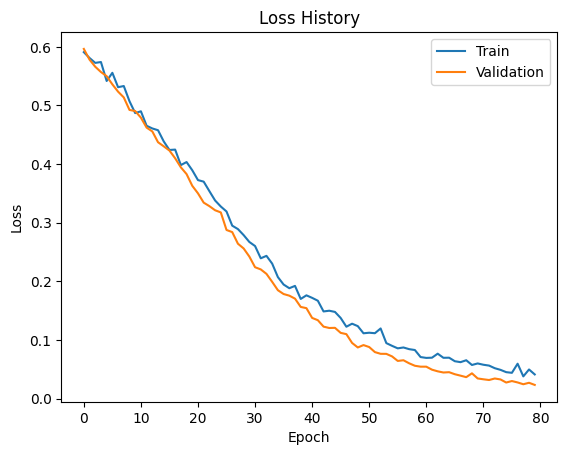

In [29]:
# Plot history
def plot_history(history): 
    loss = history['loss']
    epochs = range(len(loss))

    val_loss = history['val_loss']

    plt.plot(epochs, loss, label="Train")
    plt.plot(epochs, val_loss, label='Validation')

    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history)

In [57]:
# Making a different testing set (So people can see the in-domain vs out-of-domain)

test_generator = SkyGenerator(n_samples=1280, train=False, shuffle=True)

def make_prediction(test_generator): 
    predictions = model.predict(test_generator)
    prediction_classes = np.where(predictions<0.5, 0, 1) # Challenge - make this backwards
    labels = test_generator.labels
    return prediction_classes, labels

def test_quality(prediction, labels): 
    accuracy = tf.keras.metrics.BinaryAccuracy()(prediction, labels)
    return accuracy.numpy()

In [59]:
prediction, labels = make_prediction(test_generator)

test_quality(prediction, labels)

20/20 [==============================] - 1s 25ms/step


0.99921876

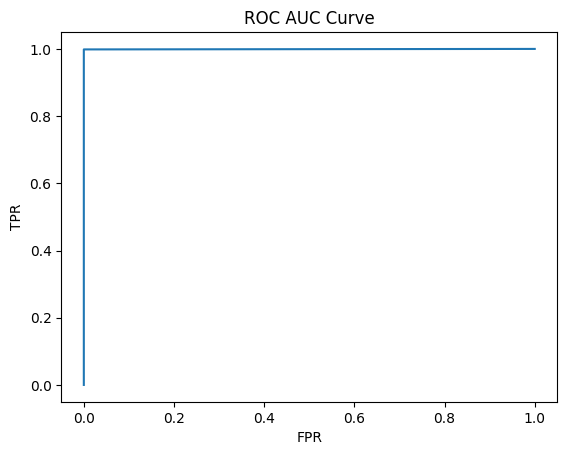

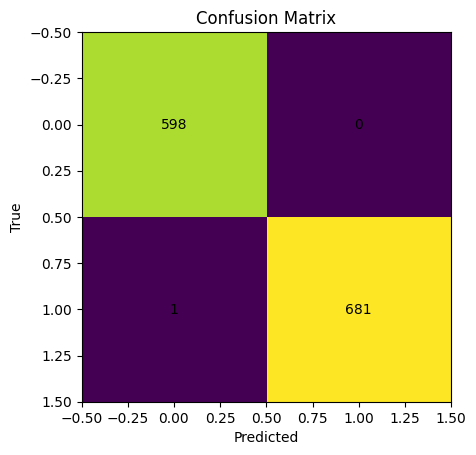

In [60]:
# Metrics and evaluation
def plot_test_results(predictions, labels):
    score_fpr, score_tpr, _ = roc_curve(labels, predictions)
    confusion = confusion_matrix(labels.ravel(), predictions.ravel())

    plt.plot(score_fpr, score_tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC AUC Curve")
    plt.show()


    plt.imshow(confusion)

    for true in range(confusion.shape[0]):
        for predicted in range(confusion.shape[1]):
            plt.text(predicted, true, confusion[true, predicted],
                        ha="center", va="center")
            
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_test_results(prediction, labels)